# Assignment 2 - Object Detection | Semantic Segmentation

This notebook contains the required task for the second assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing your task [Object Detection or Semantic Segmantation], from loading and inspecting the dataset to testing a **pre-trained** model. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise inference can be very slow.

## Rules and Comments
- From the list of datasets and tasks listed in canvas, each student was atributed **1 task and 1 dataset** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- The emphasis of this assignment is put in the way you use and compare the different models. The metrics you present are very important.
- As always, copying others' code will make you fail the homework automatically (and thus the course). 
- **Deadline is April 24**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Tshifaro Ndivhuwo Justin**  
**Neptun ID:SUQG0J** 

## Task description
Given your task (Semantic Segmentation or Object Detection), you have to test three (3) pretrained models on the test set of a given dataset, comparing the results between the models. For the comparison, you have to use at least three (3) metrics commonly used in your task.

For example, if student A is given Object Detection task and the Ballons v2 dataset, then his/her task is to choose 3 pretrained object detection models [R-CNN, YOLO, ...] and evaluate them on the Ballons v2 test set, comparing the results using 3 metrics [mAP, Recall, ...]. If a dataset does not have a testing set, then the student should split at least 10% of the training set to create the test set.

For running test/evaluation/inference on a pre-trained model, it is important to know what are the model requirements, so that the input is preprocessed accordingly.
Make sure to explore the data and **present detailed evaluation metrics**.

**Please answer the questions.**



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [152]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.utils.data import Dataset, random_split, DataLoader 
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import glob
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms 
from torchvision.datasets import VOCDetection
import torchvision.datasets as datasets
import  torchvision
from google.colab.patches import cv2_imshow

## 1. Dataset 
Load the dataset you were given. If your data does not have a test set, split a portion of your training set (at least 10%).
Explore the dataset by visualizing the images and annotations.


#### Loading the dataset
Show some images and annotations of your dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = datasets.VOCDetection('/content/Data',year='2012', download=True)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting /content/Data/VOCtrainval_11-May-2012.tar to /content/Data


In [ ]:
df_train =dataset
len(df_train) 

5717

In [ ]:
train_data,test_data = random_split(df_train, [4200, 1517])
len(train_data), len(test_data)

(4200, 1517)

In [ ]:
for i, sample in enumerate(train_data, 1):
    print(sample)
    image_data, annotation_image = sample[0], sample[1]['annotation']
    objects = annotation_image['object']
    show_image = np.array(image_data)
    print('{} object:{}'.format(i, len(objects))) # how many object it contain
    print(show_image.shape)
    print(objects)
    if i == 2:
      break
len(train_data)

(<PIL.Image.Image image mode=RGB size=500x321 at 0x7FF6753A5410>, {'annotation': {'filename': '2011_002746.jpg', 'folder': 'VOC2012', 'object': [{'name': 'dog', 'bndbox': {'xmax': '287', 'xmin': '1', 'ymax': '321', 'ymin': '47'}, 'difficult': '0', 'occluded': '0', 'pose': 'Right', 'truncated': '1'}, {'name': 'dog', 'bndbox': {'xmax': '350', 'xmin': '250', 'ymax': '187', 'ymin': '69'}, 'difficult': '0', 'occluded': '0', 'pose': 'Right', 'truncated': '1'}], 'segmented': '0', 'size': {'depth': '3', 'height': '321', 'width': '500'}, 'source': {'annotation': 'PASCAL VOC2011', 'database': 'The VOC2011 Database', 'image': 'flickr'}}})
1 object:2
(321, 500, 3)
[{'name': 'dog', 'bndbox': {'xmax': '287', 'xmin': '1', 'ymax': '321', 'ymin': '47'}, 'difficult': '0', 'occluded': '0', 'pose': 'Right', 'truncated': '1'}, {'name': 'dog', 'bndbox': {'xmax': '350', 'xmin': '250', 'ymax': '187', 'ymin': '69'}, 'difficult': '0', 'occluded': '0', 'pose': 'Right', 'truncated': '1'}]
(<PIL.Image.Image image 

4200

In [ ]:
train_data[0]

(<PIL.Image.Image image mode=RGB size=500x321 at 0x7FF58E4F0190>,
 {'annotation': {'filename': '2011_002746.jpg',
   'folder': 'VOC2012',
   'object': [{'bndbox': {'xmax': '287',
      'xmin': '1',
      'ymax': '321',
      'ymin': '47'},
     'difficult': '0',
     'name': 'dog',
     'occluded': '0',
     'pose': 'Right',
     'truncated': '1'},
    {'bndbox': {'xmax': '350', 'xmin': '250', 'ymax': '187', 'ymin': '69'},
     'difficult': '0',
     'name': 'dog',
     'occluded': '0',
     'pose': 'Right',
     'truncated': '1'}],
   'segmented': '0',
   'size': {'depth': '3', 'height': '321', 'width': '500'},
   'source': {'annotation': 'PASCAL VOC2011',
    'database': 'The VOC2011 Database',
    'image': 'flickr'}}})

In [ ]:
def show_object_rect(image, bndbox):
    pt1 = bndbox[:2]
    pt2 = bndbox[2:]
    image_show = image
  
    return cv2.rectangle(image_show, pt1,pt2, (0,255,255), 2)

def show_object_name(image: np.ndarray, name: str, p_tl):
    return cv2.putText(image, name, p_tl, 1, 1, (0, 0, 255))

1 object:2
(321, 500, 3)
(321, 500, 3)


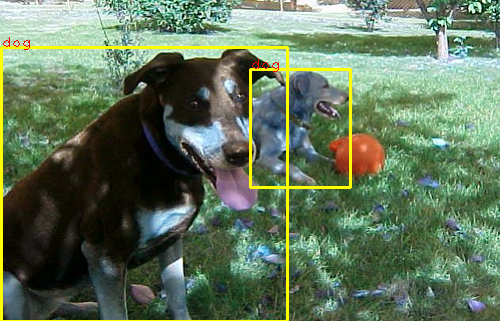

2 object:8
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)
(375, 500, 3)


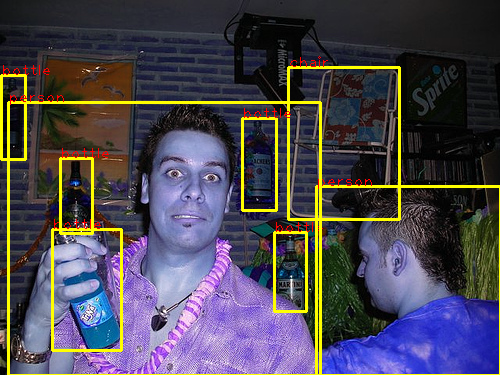

3 object:3
(500, 371, 3)
(500, 371, 3)
(500, 371, 3)


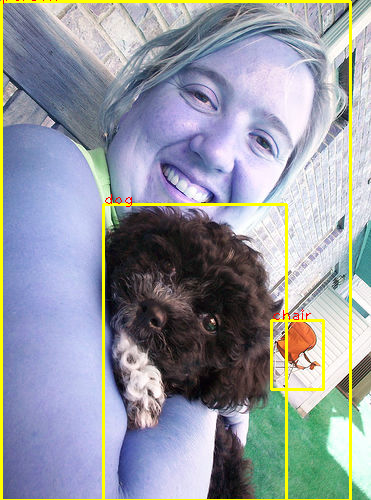

4 object:1
(333, 500, 3)


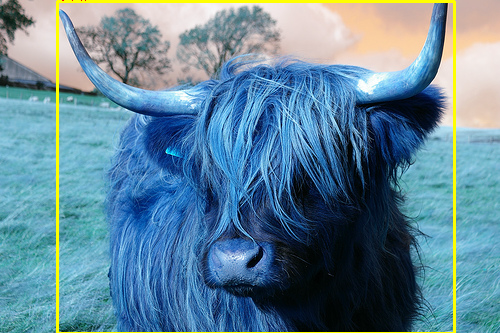

In [ ]:
# show some results
for i, sample in enumerate(train_data, 1):
    image, annotation = sample[0], sample[1]['annotation']
    objects = annotation['object']
    show_image = np.array(image)
    print('{} object:{}'.format(i, len(objects)))
    if not isinstance(objects,list):
        object_name = objects['name']
        object_bndbox = objects['bndbox']
        x_min = int(object_bndbox['xmin'])
        y_min = int(object_bndbox['ymin'])
        x_max = int(object_bndbox['xmax'])
        y_max = int(object_bndbox['ymax'])
        show_image = show_object_rect(show_image, (x_min, y_min, x_max, y_max))
        show_image =show_object_name(show_image, object_name, (x_min, y_min))
    else:
        for j in objects:
            object_name = j['name']
            object_bndbox = j['bndbox']
            x_min = int(object_bndbox['xmin'])
            y_min = int(object_bndbox['ymin'])
            x_max = int(object_bndbox['xmax'])
            y_max = int(object_bndbox['ymax'])
            print(show_image.shape)
            show_image = show_object_rect(show_image, (x_min, y_min, x_max, y_max))
            show_image = show_object_name(show_image, object_name, (x_min, y_min))

    cv2_imshow(show_image)
    if i>3:
      break

In [ ]:
classes = ['person','bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
           'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
           'bottle', 'chair', 'dining' 'table', 'potted' 'plant', 'sofa', 'tvmonitor'
           ]

#### Pre-processing the dataset

In [ ]:
mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
class load_data(Dataset):
  def __init__(self, data_image):

    super(load_data, self).__init__()

    self.data_image = data_image

  def __len__(self):
    return len(self.data_image)
  def __getitem__(self,index):
    data = self.data_image[index]
    image, annotation = data[0], data[1]['annotation']
    origial = np.array(image)
    objects = annotation['object']
    image_x = transformations(image)
    box = []
    if not isinstance(objects,list):
        temp = []
        object_name = objects['name']
        object_bndbox = objects['bndbox']
        temp.append(int(classes.index(object_name)))
        temp.append(int(object_bndbox['xmin']))
        temp.append(int(object_bndbox['ymin']))
        temp.append(int(object_bndbox['xmax']))
        temp.append(int(object_bndbox['ymax']))
        box.append(temp)
    else:
        for j in objects:
            temp = []
            object_name = j['name']
            object_bndbox = j['bndbox']
            temp.append(int(classes.index(object_name)))
            temp.append(int(object_bndbox['xmin']))
            temp.append(int(object_bndbox['ymin']))
            temp.append(int(object_bndbox['xmax']))
            temp.append(int(object_bndbox['ymax']))
            box.append(temp)
    res = {}
    # print(type(image_x))
    return origial,image_x,box,classes.index(object_name)

In [ ]:
test_data_load = load_data(test_data)

In [104]:
batch_size = 1

train_dl = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_data_load,batch_size=batch_size,drop_last=False,pin_memory=True)

In [ ]:
def draw_reslut(data,box_data):
  for box in box_data:
      data = show_object_rect(data, (int(box[0]),int(box[1]),int(box[2]),int(box[3])))
  print()
  cv2_imshow(data)

## 2. Models
Load the 3 chosen models for your given task. Show the model's architecture.

Yolo runs a lot faster than faster rcnn due it's simpler architecture. Unlike faster RCNN, it's trained to do classification and bounding box regression at the same time.

YOLO is an open-source object detection system. It can recognize objects on a single image or a video stream rapidly. SSD (Single-Shot Multi-box Detection) detects objects with high precision in a single forward pass computing feature map.

### Question 1
Describe the main differences between the models you chose.

ADD ANSWER HERE

#### Load the models
Show the architectures

**SSD300**

In [ ]:
import torch
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [218]:
images_path = Path('/content/Data/VOCdevkit/VOC2012/JPEGImages')
anno_path = Path('/content/Data/VOCdevkit/VOC2012/Annotations')

In [221]:
def filelist(root, file_type):

    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
             files in os.walk(root) for f in files if f.endswith(file_type)]

    # an easier solution to collect files in a folder:
    #return glob.glob(f'{images_path}/*.{file_type}')

In [222]:
images = filelist(images_path, '.jpg')

In [223]:
len(images)

17125

In [231]:
inputs = [utils.prepare_input(uri) for uri in images[:40]]
tensor = utils.prepare_tensor(inputs)

In [232]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [233]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [234]:
classes_to_labels = utils.get_coco_object_dictionary()

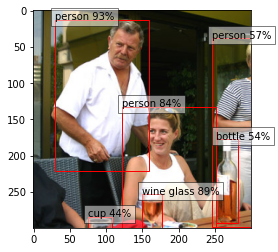

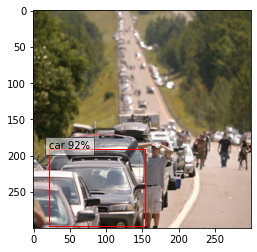

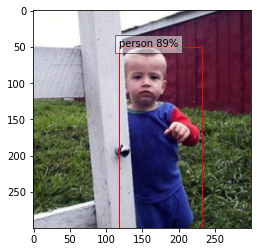

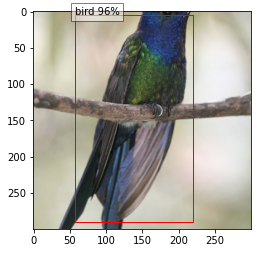

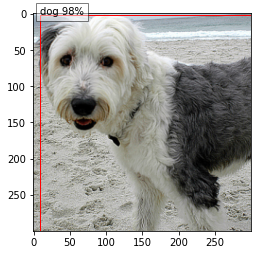

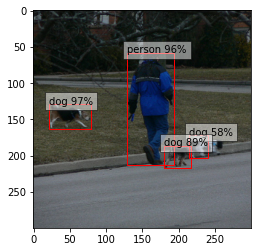

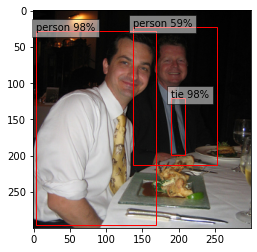

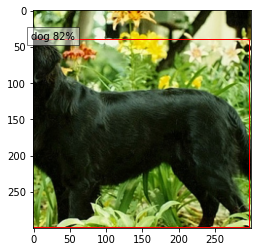

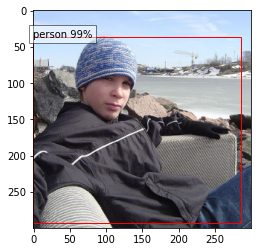

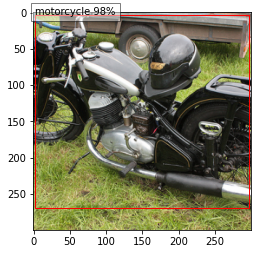

In [235]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

**Yolo Model**

In [236]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 13094, done.
remote: Total 13094 (delta 0), reused 0 (delta 0), pack-reused 13094
Receiving objects: 100% (13094/13094), 11.98 MiB | 7.34 MiB/s, done.
Resolving deltas: 100% (9103/9103), done.
/content/yolov5/yolov5


In [237]:
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True,force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


ImportError: ignored

In [243]:
img = ['test.jpg']
results = model_yolo(test_data[8][0])

NameError: ignored

In [ ]:
def trans_str_int(name):
  if name in classes:
    return classes.index(name)
  else:
    return 90

In [ ]:
result = results.pandas().xyxy[0]

result

In [ ]:
results.print()

In [ ]:
results.show()
results.save()

**FASTER RCNN**

In [238]:
model_frcnn = models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # based on coco
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_frcnn = model_frcnn.to(device)
model_frcnn.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [239]:
import pandas as pd
def clean_faster_rcnn(data):
  result = pd.DataFrame(data, columns = ['xmin',	'ymin',	'xmax',	'ymax',	'confidence',	'class',	'name'])
  result['class'] = result['name'].apply(trans_str_int)
  result.drop(result[result['class'] == 90].index,inplace=True)
  result.drop("name",axis=1,inplace=True)
  return result

In [240]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
classes = ['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor',]

In [241]:
def faster_rcnn():
  for index, data in enumerate(test_dl):
  
    origial,image_x, original_boxs, origial_labels = data
   
    image_x = image_x.to(device)
    out = model_frcnn(image_x)[0]

    labels = out["labels"].detach().to('cpu').numpy()
    boxes = out["boxes"].detach().to('cpu').numpy()
    scores = out["scores"].detach().to('cpu').numpy()
    result = []
    for i in range(len(labels)):
      temp = [int(da) for da in boxes[i]]
      temp.append(scores[i])
      temp.append(labels[i])
      temp.append(COCO_INSTANCE_CATEGORY_NAMES[labels[i]])
      result.append(temp)
    result = np.array(result)
    if len(result)>=1:
      result = clean_faster_rcnn(result)
      result = result.to_numpy().astype(float)
    if len(result)>=1:
      get_confusion_matrix_yolo(20,result,np.array(original_boxs),0.006,0.2)
  #return origial, out,boxs, name

In [242]:
faster_rcnn()

RuntimeError: ignored

In [ ]:
oa = Over_Accuracy(matrix[:20,:20])
oa

In [ ]:
aa = Average_Accuracy(matrix[1:19,1:19])
aa

In [ ]:
recall = Recall(matrix[1:20,:20])
recall

In [ ]:
def test_faster_rcnn():
  for i, data in enumerate(test_dl):
    # print(data[1].shape)
    origial,image_x, boxs, name = data
    # print(type(image_x))
    image_x = image_x.to(device)
    out = model_frcnn(image_x)
    #(num_classes, detections, labels, CONF_THRESHOLD,IOU_THRESHOLD):
    get_confusion_matrix(21,)

    labels_pre_ = out[0]['labels'].detach().numpy()
    boxes_pre_ = out[0]['labels'].detach().numpy()
    scores_pre_ = out[0]['scores'].detach().numpy()
    
  return origial,out,boxs, name

In [ ]:
def val():
  for index, data in enumerate(test_dl):
    min_score=0.4
    max_overlap=0.6
    top_k=200
    origial,image_x, original_boxs, origial_labels = data
 #   print((image_x.shape))
    image_x = image_x.to(device)
    predicted_locs, predicted_scores = model_frcnn(image_x)
    det_boxes, det_labels, det_scores = model_frcnn.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    det_boxes = list(det_boxes[0].detach().to('cpu').numpy())
    det_labels = det_labels[0].detach().to('cpu').numpy()
    det_scores = det_scores[0].detach().to('cpu').numpy()
    origial_image = origial.squeeze(0)
    original_dims = np.array([origial_image.shape[1], origial_image.shape[0], origial_image.shape[1], origial_image.shape[0]])
    det_boxes = det_boxes * original_dims
    result = []
    for i in range(len(det_labels)):
      # detections (Array[N, 6]), x1, y1, x2, y2, conf, class
      temp = list(det_boxes[i])
      temp.append(det_scores[i])
      temp.append(det_labels[i]-1)
      result.append(temp)
     #(num_classes, detections, labels, CONF_THRESHOLD,IOU_THRESHOLD):
    get_confusion_matrix(21,np.array(result),np.array(original_boxs),0.4,0.2)
    print(index)

In [ ]:
def faster_rcnn_draw():
  for index, data in enumerate(test_dl):
  
    origial,image_x, original_boxs, origial_labels = data
   
    image_x = image_x.to(device)
    out = model_frcnn(image_x)[0]

    labels = out["labels"].detach().to('cpu').numpy()
    boxes = out["boxes"].detach().to('cpu').numpy()
    scores = out["scores"].detach().to('cpu').numpy()
    result = []
    
    for i in range(len(labels)):
      temp = [int(da) for da in boxes[i]]
      temp.append(scores[i])
      temp.append(labels[i])
      temp.append(COCO_INSTANCE_CATEGORY_NAMES[labels[i]])
      result.append(temp)
    result = np.array(result)
    corner = []
    for i in range(len(scores)):
   
      if scores[i]>0.09:
        temp = [int(da) for da in boxes[i]]
        corner.append(temp)
    if len(result)>=1:
      result = clean_faster_rcnn(result)
      result = result.to_numpy().astype(float)
      origial = origial.squeeze(0).numpy()

      if len(result)>=1:
        print(corner)
        draw_reslut(origial,np.array(corner))
    if index>3:
      break
  #return origial, out,boxs, name

In [ ]:
faster_rcnn_draw()

## 3. Evaluation
This is the most important part. Please give a detailed comparison between the models.

**Implement your metrics manually**. Do not use pre defined Pytorch metrics.

Calculate the metrics for each model on the test set.

Plot the metrics.

Show some predictions in comparison to the ground truth.

#### Evaluate your models

In [ ]:
nb_classes = 20
matrix = np.zeros((nb_classes+1,nb_classes+1),dtype=int)

In [ ]:
def box_area(box):
  
    return (box[2] - box[0]) * (box[3] - box[1])
    
def cal_iou(boxes1, boxes2):
    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min = 0, a_max = None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

In [ ]:
def handle_class_int(result_):
 
  result = result_.pandas().xyxy[0]
  result['class'] = result['name'].apply(trans_str_int)
  result.drop(result[result['class'] == 90].index,inplace=True)
  result.drop("name",axis=1,inplace=True)
  return result

In [ ]:
def get_parameter(data):
    image, annotation = data[0], data[1]['annotation']
    origial = np.array(image)
    objects = annotation['object']
    image_x = transformations(image)
    box = []
    if not isinstance(objects,list):
        temp = []
        object_name = objects['name']
        object_bndbox = objects['bndbox']
        temp.append(int(classes.index(object_name)))
        temp.append(int(object_bndbox['xmin']))
        temp.append(int(object_bndbox['ymin']))
        temp.append(int(object_bndbox['xmax']))
        temp.append(int(object_bndbox['ymax']))
        box.append(temp)
    else:
        for j in objects:
            temp = []
            object_name = j['name']
            object_bndbox = j['bndbox']
            temp.append(int(classes.index(object_name)))
            temp.append(int(object_bndbox['xmin']))
            temp.append(int(object_bndbox['ymin']))
            temp.append(int(object_bndbox['xmax']))
            temp.append(int(object_bndbox['ymax']))
            box.append(temp)
    return origial,image_x,box,classes.index(object_name)

In [ ]:
def get_confusion_matrix(num_classes, detections, labels, CONF_THRESHOLD,IOU_THRESHOLD):
      # matrix = np.zeros((nb_classes+1,nb_classes+1),dtype=int)
      detections = detections[detections[:, 4] > CONF_THRESHOLD]
      gt_classes = labels[:, 0].astype(np.int16)
      detection_classes = detections[:, 5].astype(np.int16)
      all_ious = cal_iou(labels[:, 1:], detections[:, :4])
      want_idx = np.where(all_ious > IOU_THRESHOLD)
      all_matches = []
      for i in range(want_idx[0].shape[0]):
          all_matches.append([want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]])
      
      all_matches = np.array(all_matches)
      if all_matches.shape[0] > 0: # if there is match
          all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

          all_matches = all_matches[np.unique(all_matches[:, 1], return_index = True)[1]]

          all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

          all_matches = all_matches[np.unique(all_matches[:, 0], return_index = True)[1]]


      for i, label in enumerate(labels):
          if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
              gt_class = gt_classes[i]
              detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
              matrix[(gt_class), detection_class] += 1
          else:
              gt_class = gt_classes[i]
              matrix[num_classes, (gt_class)] += 1
      
      for i, detection in enumerate(detections):
          if all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0:
              detection_class = detection_classes[i]
              matrix[detection_class, num_classes] += 1
      

In [ ]:
nb_classes = 20
matrix = np.zeros((nb_classes+1,nb_classes+1),dtype=int)
def get_confusion_matrix_yolo(num_classes, detections, labels, CONF_THRESHOLD,IOU_THRESHOLD):
      # matrix = np.zeros((nb_classes+1,nb_classes+1),dtype=int)
      detections = detections[detections[:, 4] > CONF_THRESHOLD]
      gt_classes = labels[:, 0].astype(np.int16)
      detection_classes = detections[:, 5].astype(np.int16)
      all_ious = cal_iou(labels[:, 1:], detections[:, :4])
      want_idx = np.where(all_ious > IOU_THRESHOLD)
      all_matches = []
      for i in range(want_idx[0].shape[0]):
          all_matches.append([want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]])
      
      all_matches = np.array(all_matches)
      if all_matches.shape[0] > 0: # if there is match
          all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

          all_matches = all_matches[np.unique(all_matches[:, 1], return_index = True)[1]]

          all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

          all_matches = all_matches[np.unique(all_matches[:, 0], return_index = True)[1]]


      for i, label in enumerate(labels):
          if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
              gt_class = gt_classes[i]
              detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
              matrix[(gt_class), detection_class] += 1
          else:
              gt_class = gt_classes[i]
              matrix[num_classes, (gt_class)] += 1
      
      for i, detection in enumerate(detections):
          if all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0:
              detection_class = detection_classes[i]
              matrix[detection_class, num_classes] += 1


In [ ]:
def val_yolo5(model_yolo):
  for index, data in enumerate(test_data):
    origial,image_x, original_boxs, origial_labels = get_parameter(data)
    #print(index)
    result_all = model_yolo(test_data[index][0])
    result_clean = handle_class_int(result_all)
    result_clean = result_clean.to_numpy()
    get_confusion_matrix_yolo(20,result_clean,np.array(original_boxs),0.4,0.2)

In [ ]:
results = val_yolo5(model_yolo)

#### Show the metrics results

In [ ]:
def Average_Accuracy(confusion_matrix):
    true_positive = np.diag(confusion_matrix)  # TP

    condition_positive = np.sum(confusion_matrix, axis=1)  # TP+FN
    R_per_class = true_positive / (condition_positive + 1e-10)  # TP/P

    AA = np.average(R_per_class)
    return AA

In [ ]:
aa = Average_Accuracy(matrix[:20,:20])
aa

In [ ]:
def Over_Accuracy(confusion_matrix):
    OA = np.diag(confusion_matrix).sum() / (np.sum(confusion_matrix) + 1e-10)
    return OA

In [ ]:
oa = Over_Accuracy(matrix[:20,:20])
oa

In [ ]:
def Recall(confusion_matrix):
    true_positive = np.diag(confusion_matrix) # TP
    condition_positive = np.sum(confusion_matrix, axis=1) # TP+FN
    R_per_class = true_positive / (condition_positive+1e-10) # TP/P
    R = np.average(R_per_class)
    return R

In [ ]:
recall = Recall(matrix[:20,:20])
recall

#### Show some predictions

In [ ]:
def val_yolo5_showpred(model_yolo):
  for index, data in enumerate(test_data):
    origial,image_x, original_boxs, origial_labels = get_parameter(data)
    
    result_all = model_yolo(test_data[index][0])
    result_clean = handle_class_int(result_all)
    result_clean = result_clean.to_numpy()
    get_confusion_matrix_yolo(20,result_clean,np.array(original_boxs),0.4,0.2)
    if len(result_clean)>=2:
      draw_reslut(origial, result_clean[:,:4])
    if index >5:
      break

In [ ]:
val_yolo5_showpred(model_yolo)

## 4. Conclusion

### Answer the questions
#### Question 2. 
Which model performed the best? Why do you think it performed better than others?

#### Question 3. 
How could you improve the performance of the models?



 **Question 2**

SSD performance is the best because it is training on the corresponding data set.


 **Question 3**

We can add more data or We can do more training,